In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import promethee_functions as pf

# Promethee Gamma application on the HDI datasets

## 1. Read data + scaling

In [62]:
data = read_data()
data.head()
data = scale_data(data)

# Keep only 3 rows
# data = data.iloc[:3]

data.head()

,iso3,co2prod,poptotal,hdi,le,gdi,eys
6,ARG,"[0.19043556311874693, 0.19708748799126294, 0.2...","[0.020942210735571794, 0.021273226668040518, 0...","[0.5945945945945946, 0.6072072072072072, 0.616...","[0.6871611693773119, 0.7007143942848458, 0.703...","[0.8944954128440368, 0.897553516819572, 0.9021...","[0.5926342789353461, 0.5900415074178023, 0.587..."
13,BGD,"[0.0, 0.00020324003233878132, 0.00039189643114...","[0.07363106531814378, 0.07511264935926601, 0.0...","[0.009009009009009018, 0.005405405405405411, 0...","[0.28702437047170287, 0.24053807569539457, 0.3...","[0.5504587155963303, 0.562691131498471, 0.5948...","[0.08428075131536233, 0.09739828033109835, 0.1..."
34,CHL,"[0.1346361578106482, 0.12376605861463034, 0.12...","[0.007298131007744375, 0.00745304905085084, 0....","[0.5603603603603603, 0.5765765765765766, 0.590...","[0.7071743426052592, 0.7325074732735471, 0.746...","[0.8348623853211011, 0.8287461773700308, 0.836...","[0.5508978220705721, 0.5501915953125217, 0.549..."
49,DOM,"[0.06469952971594471, 0.06798756908874576, 0.0...","[0.002904071138475708, 0.0030097161536142758, ...","[0.33333333333333326, 0.34414414414414407, 0.3...","[0.5687541166337337, 0.581800678927902, 0.5934...","[0.8042813455657494, 0.8058103975535169, 0.824...","[0.32670458509909345, 0.3376523004281499, 0.34..."
51,EGY,"[0.06822751811186913, 0.06846610435211249, 0.0...","[0.03832152498536217, 0.039308973663436976, 0....","[0.31171171171171164, 0.32432432432432423, 0.3...","[0.4936667173329281, 0.5090945939099153, 0.516...","[0.6681957186544343, 0.6620795107033639, 0.677...","[0.3216704685479691, 0.32447622645404717, 0.33..."


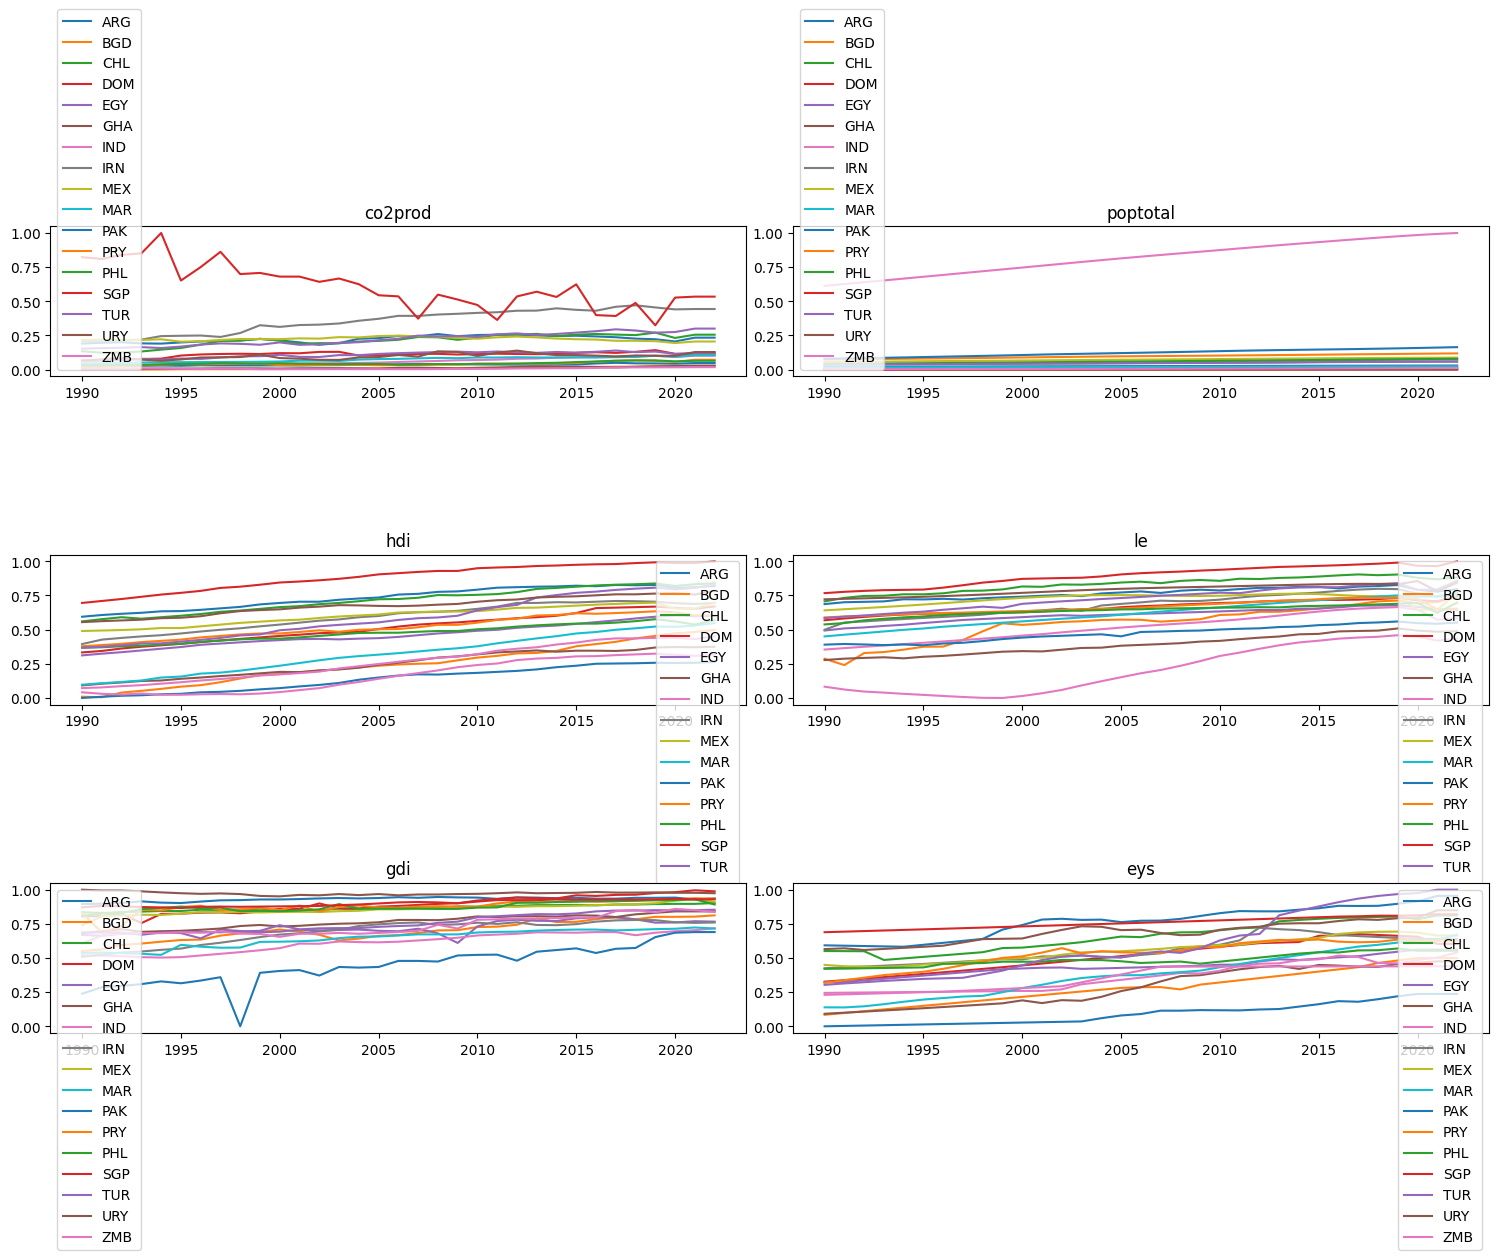

In [63]:
plot_data(data, legend=True)

## 2. Construct the PHI_c time series
1. Create k matrices of size $n\times n$ with $P_c(a_i,a_j)$, where each element is a sequence
2. Create k lists of sequences (one per criteria): $\phi^c(a_i)$

In [64]:
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.shape[0] # Number of time series
K = data.columns.shape[0] -1 # Number of features

W = [1/K for _ in range(K)]
P = [0.9 for _ in range(K)]
Q = [0.1 for _ in range(K)]

print("L:", L)
print("N:", N)
print("K:", K)

L: 33
N: 17
K: 6


In [65]:
def linear_P_c(a_i, a_j, c):
    """ 
    Returns: The preference function within criteria c, linear version
    - a_i: a multi-criteria time series
    - a_j: a multi-criteria time series
    - c: the criteria identifier
    """
    d = a_i[c] - a_j[c]
    for i in range(len(d)): # For each time step
        if d[i] <= Q[c-1]:
            d[i] = 0
        elif d[i] > P[c-1]:
            d[i] = 1
        else:
            d[i] = (d[i] - Q[c-1]) / (P[c-1] - Q[c-1])
    return d

def P_c_matrix(data, c):
    """
    Returns: The preference matrix within criteria c, size NxN where each cell is a time series
    - data: the multi-criteria time series data
    - c: the criteria identifier
    """
    N = data.shape[0]
    P_c = np.zeros((N, N, L))
    for i in range(N):
        for j in range(N):
            if i != j:
                P_c[i][j] = linear_P_c(data.iloc[i], data.iloc[j], c+1)
    return P_c

print("P_c_matrix(data, 0).shape:", P_c_matrix(data, 0).shape)

P_c_matrix(data, 0).shape: (17, 17, 33)


C:\Users\raphu\AppData\Local\Temp\ipykernel_165752\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


PHI_0.shape: (17, 33)


C:\Users\raphu\AppData\Local\Temp\ipykernel_165752\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


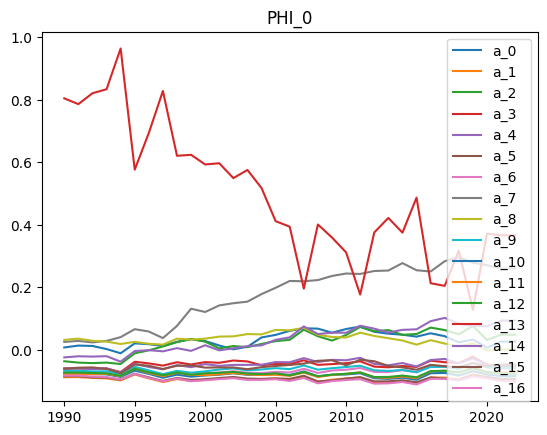

In [66]:
def get_Phi_c_ai(i, P_c):
    """
    Returns: The preference function for a_i within criteria c
    Phi_c(a_i) = 1/N-1 sum_j (P_c(a_i, a_j) - P_c(a_j, a_i))
    - a_i: a multi-criteria time series
    - P_c: the preference matrix within criteria c
    - c: the criteria identifier
    """
    N = P_c.shape[0]
    sum = 0
    for j in range(N):
        sum += P_c[i][j] - P_c[j][i] 
    return 1/(N-1) * sum


def get_Phi_c(data, c):
    """
    Returns: The preference function for all time series within criteria c
        - Phi_c is a list of size N where each cell is a time series
    - data: the multi-criteria time series data
    - c: the criteria identifier
    """
    P_c = P_c_matrix(data, c)
    N = data.shape[0]
    Phi_c = np.zeros((N, L))
    for i in range(N):
        Phi_c[i] = get_Phi_c_ai(i, P_c)
    return Phi_c




PHI_0 = get_Phi_c(data, 0)

print("PHI_0.shape:", PHI_0.shape)

def plot_Phi_c_ai(PHI_c, title):
    """
    PHI_c is a list of N time series, plot each time series in the same plot
    """
    x = np.arange(1990, 2023)
    N = PHI_c.shape[0]
    for i in range(N):
        plt.plot(x, PHI_c[i], label=f"a_{i}")
    plt.title(title)
    plt.legend()
    plt.show()

plot_Phi_c_ai(PHI_0, "PHI_0")


C:\Users\raphu\AppData\Local\Temp\ipykernel_165752\4179098351.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]
C:\Users\raphu\AppData\Local\Temp\ipykernel_165752\2443908857.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


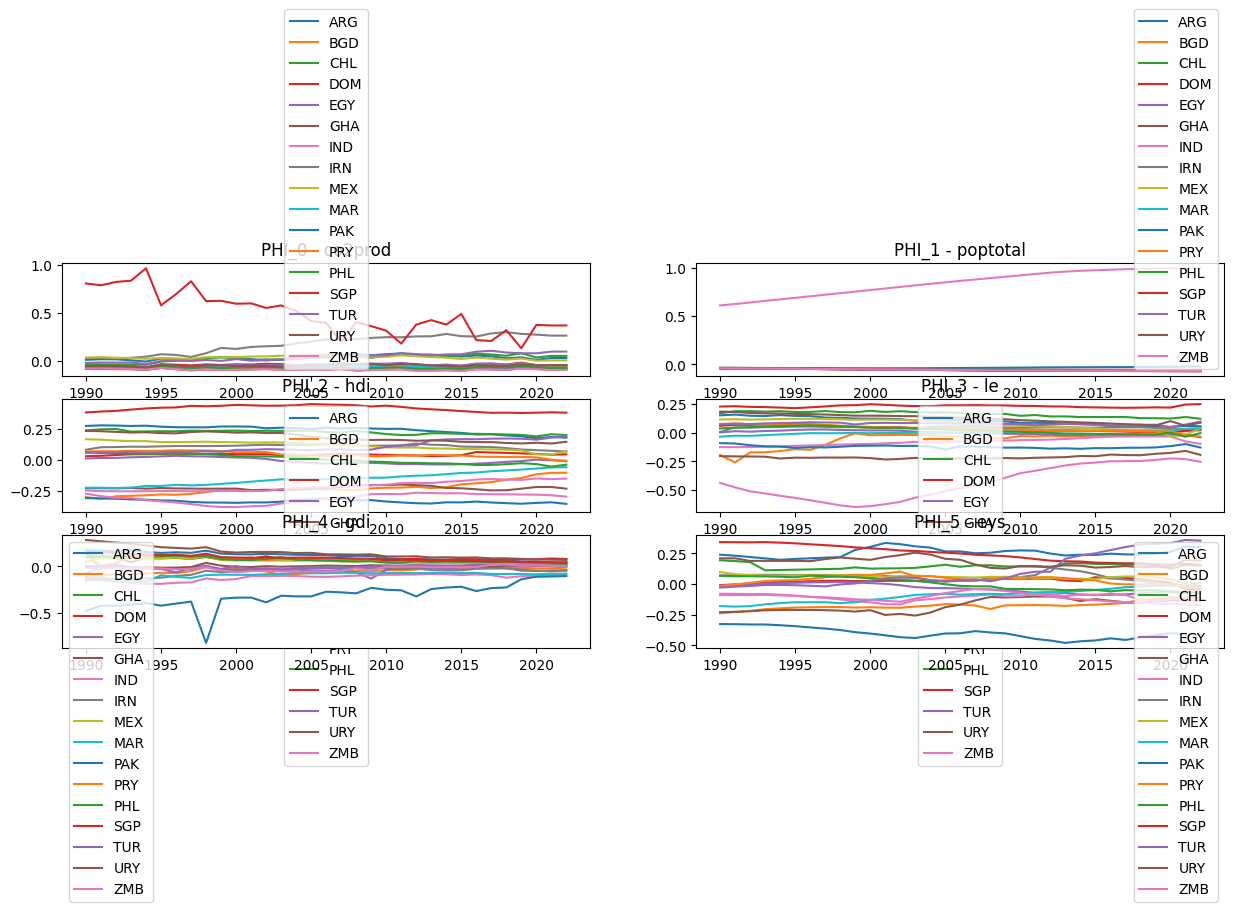

In [67]:
def get_all_Phi_c(data):
    """
    Returns: A list of all preference functions for all criteria
    Format: [PHI_0, PHI_1, ..., PHI_K]
     - PHI_c = [PHI_c(a_0), PHI_c(a_1), ..., PHI_c(a_N)]
    """
    return [get_Phi_c(data, c) for c in range(K)]

PHI_c_all = get_all_Phi_c(data)

def plot_phi_c_all(PHI_c_all, col_names, alt_names):
    """"
    Returns subplots for each criteria
    - PHI_c_all: A list of k lists of N time series
    """
    plt.figure(figsize=(15, 5))
    x = np.arange(1990, 2023)
    for c in range(K):
        plt.subplot((K + 1) // 2, 2, c + 1)
        PHI_c = PHI_c_all[c]
        for i in range(N):
            plt.plot(x, PHI_c[i], label=alt_names[i])
        plt.title(f"PHI_{c} - {col_names[c]}")
        plt.legend()
    plt.tight_layout()

column_names = data.columns[1:]
alternative_names = data["iso3"].values

plot_phi_c_all(PHI_c_all, column_names, alternative_names)

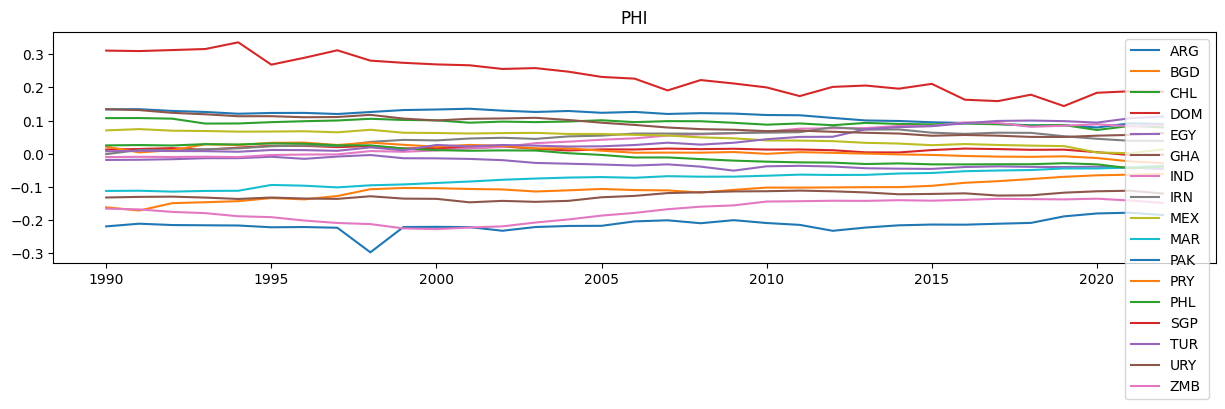

In [68]:
def PHI_all(PHI_c_all, W):
    """
    Returns: The aggregated preference function
    PHI = sum(W_c * PHI_c)
    """
    PHI = np.zeros((N, L))
    for c in range(K):
        PHI += W[c] * PHI_c_all[c]
    return PHI

PHI = PHI_all(PHI_c_all, W)

def plot_PHI(PHI, alt_names):
    """
    Plot the aggregated preference function
    """
    x = np.arange(1990, 2023)
    plt.figure(figsize=(15, 3))
    for i in range(N):
        plt.plot(x, PHI[i], label=alt_names[i])
    plt.title("PHI")
    plt.legend()
    plt.show()

plot_PHI(PHI, alternative_names)

# 3. Compute gammas
- We here have a list of mono-criterion net flow scores
- We want to compute the gamma time series for each pair of alternatives
$$\gamma(a_i,a_j, t)=\sum_{f_c(a_i, t) > f_c(a_j,t)} w_c \cdot (\phi_c(a_i,t)-\phi_c(a_j,t))$$



In [69]:
data

,iso3,co2prod,poptotal,hdi,le,gdi,eys
6,ARG,"[0.19043556311874693, 0.19708748799126294, 0.2...","[0.020942210735571794, 0.021273226668040518, 0...","[0.5945945945945946, 0.6072072072072072, 0.616...","[0.6871611693773119, 0.7007143942848458, 0.703...","[0.8944954128440368, 0.897553516819572, 0.9021...","[0.5926342789353461, 0.5900415074178023, 0.587..."
13,BGD,"[0.0, 0.00020324003233878132, 0.00039189643114...","[0.07363106531814378, 0.07511264935926601, 0.0...","[0.009009009009009018, 0.005405405405405411, 0...","[0.28702437047170287, 0.24053807569539457, 0.3...","[0.5504587155963303, 0.562691131498471, 0.5948...","[0.08428075131536233, 0.09739828033109835, 0.1..."
34,CHL,"[0.1346361578106482, 0.12376605861463034, 0.12...","[0.007298131007744375, 0.00745304905085084, 0....","[0.5603603603603603, 0.5765765765765766, 0.590...","[0.7071743426052592, 0.7325074732735471, 0.746...","[0.8348623853211011, 0.8287461773700308, 0.836...","[0.5508978220705721, 0.5501915953125217, 0.549..."
49,DOM,"[0.06469952971594471, 0.06798756908874576, 0.0...","[0.002904071138475708, 0.0030097161536142758, ...","[0.33333333333333326, 0.34414414414414407, 0.3...","[0.5687541166337337, 0.581800678927902, 0.5934...","[0.8042813455657494, 0.8058103975535169, 0.824...","[0.32670458509909345, 0.3376523004281499, 0.34..."
51,EGY,"[0.06822751811186913, 0.06846610435211249, 0.0...","[0.03832152498536217, 0.039308973663436976, 0....","[0.31171171171171164, 0.32432432432432423, 0.3...","[0.4936667173329281, 0.5090945939099153, 0.516...","[0.6681957186544343, 0.6620795107033639, 0.677...","[0.3216704685479691, 0.32447622645404717, 0.33..."
65,GHA,"[0.0055385741600501755, 0.006622806387475614, ...","[0.008786030145505738, 0.009066402969973155, 0...","[0.09189189189189188, 0.1045045045045045, 0.11...","[0.2776764452551046, 0.2876070324770736, 0.293...","[0.6804281345565749, 0.6957186544342508, 0.711...","[0.09176769307926358, 0.09956792899882028, 0.1..."
77,IND,"[0.03071051586307429, 0.03233810237958616, 0.0...","[0.6133927551457654, 0.626467449058006, 0.6396...","[0.07207207207207204, 0.07747747747747745, 0.0...","[0.3544864974413539, 0.3646957491006739, 0.374...","[0.518348623853211, 0.5168195718654435, 0.5137...","[0.24461818214461784, 0.24601820673580896, 0.2..."
79,IRN,"[0.2093959165249723, 0.2129976090211361, 0.212...","[0.03731668071047612, 0.03887044268917247, 0.0...","[0.3945945945945946, 0.42702702702702705, 0.43...","[0.49926533921061983, 0.5522622485686782, 0.56...","[0.5091743119266056, 0.5244648318042814, 0.539...","[0.4250296063285897, 0.4312164596682576, 0.437..."
112,MEX,"[0.21612716459855164, 0.22080542720023616, 0.2...","[0.05565050762147626, 0.056803968278453194, 0....","[0.4900900900900902, 0.4936936936936938, 0.497...","[0.6412322034757058, 0.6495161372042358, 0.657...","[0.7400611620795108, 0.8042813455657494, 0.810...","[0.4494348490914467, 0.43958361093357223, 0.43..."
118,MAR,"[0.04475012801408869, 0.047084309784844146, 0....","[0.015237838850704203, 0.015532905650941523, 0...","[0.09729729729729729, 0.10810810810810811, 0.1...","[0.4506510614581751, 0.46326696053098243, 0.47...","[0.536697247706422, 0.5397553516819572, 0.5351...","[0.13884315789067497, 0.1382372141695605, 0.14..."


In [ ]:
def gamma_ai_aj(ai, aj, PHI_c_all, W, L, criterias):
    """ 
    Compute the gamma value between two alternatives
    - ai: a multi-criteria time series
    - aj: a multi-criteria time series
    - PHI_c_all: A list of k lists of N time series
    - W: The weights of the criteria
    - criterias: the criteria names

    Returns:
     - gamma(ai, aj): a time series of size L where each cell is the sum of the weighted differences between PHI_c(ai) and PHI_c(aj) for the times where ai is preferred to aj

    gamma(ai, aj) = sum_c (W_c * (PHI_c(ai) - PHI_c(aj))) but only for the times where ai is preferred to aj
    """
    # Initialize gamma list of L zeros
    gamma = [0 for _ in range(L)]
    for t in range(L): # For each time step
        # Check if the value of ai is preferred to aj
        c_nb=0
        for c in criterias:
            if ai[c][t] > aj[c][t]: # If ai has a higher value than aj (the value is the score)
                gamma[t] += W[c_nb]*PHI_c_all[c_nb][0][t]
            c_nb += 1

    return gamma



def get_gamma_matrix(data, PHI_c_all, W):
    """
    Returns: The gamma matrix, size NxN where each cell is a time series
    - data: the multi-criteria time series data
    - PHI_c_all: A list of k lists of N time series
    - W: The weights of the criteria
    """
    criterias = data.columns[1:]

    L = data.iloc[0][criterias[1]].shape[0] # Length of the time series
    N = data.shape[0] # Number of time series/alternatives

    gamma_matrix = np.zeros((N, N, L))
    for i in range(N):
        for j in range(N):
            if i != j:
                gamma_matrix[i][j] = gamma_ai_aj(data.iloc[i], data.iloc[j], PHI_c_all, W, L, criterias)
    return gamma_matrix

In [71]:
get_gamma_matrix(data, PHI_c_all, W).shape

(17, 17, 33)

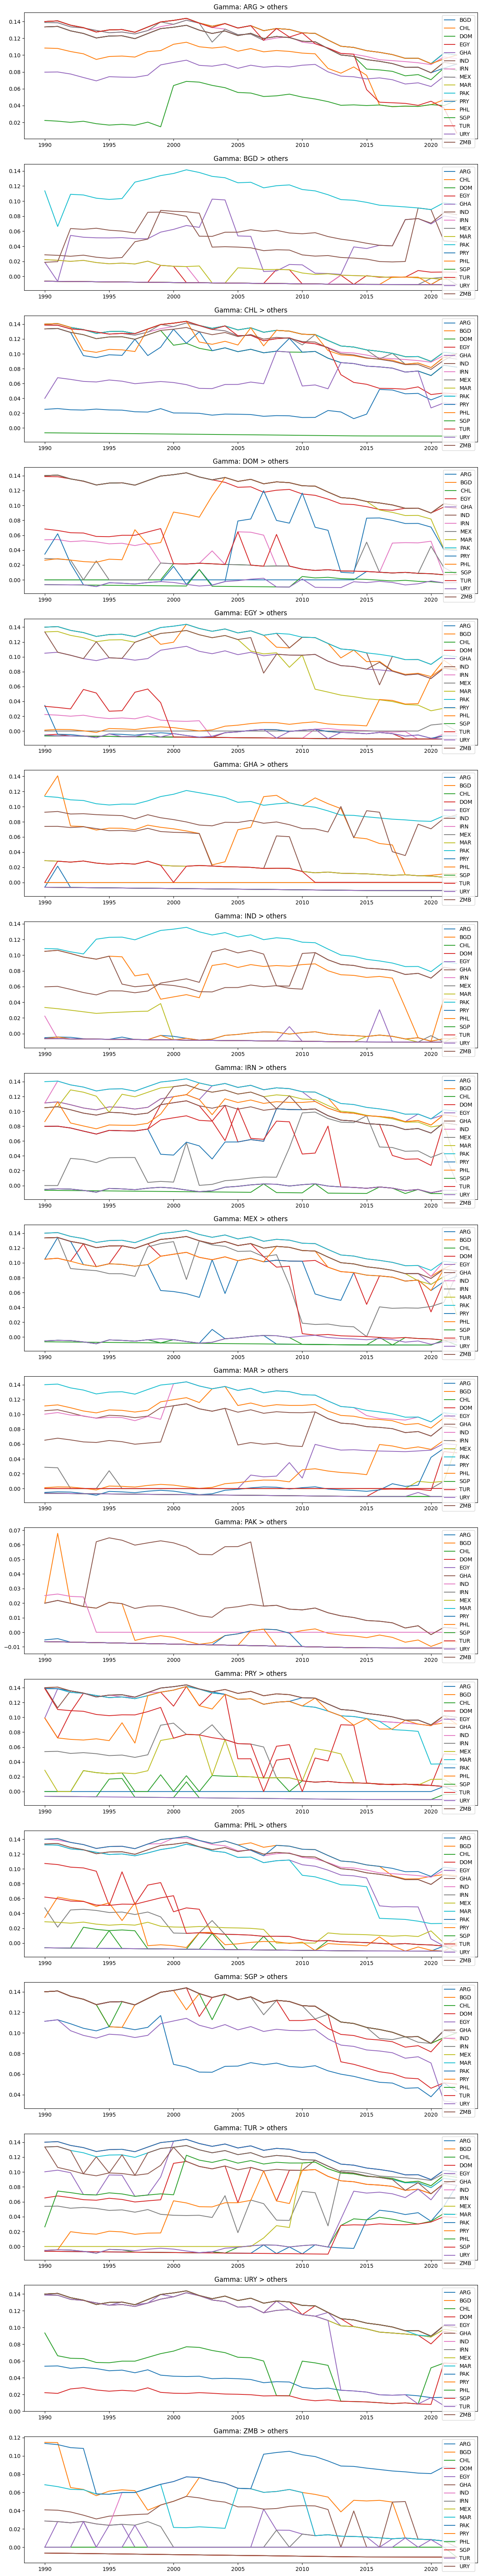

In [76]:
def plot_gammas(gamma_matrix, alt_names):
    """
    Plot the gamma matrix for each pair of alternatives
    """
    N = gamma_matrix.shape[0]
    x = np.arange(1990, 2023)
    fig, axes = plt.subplots(N, 1, figsize=(15, 5*N))
    for i in range(N):
        for j in range(N):
            if i != j:
                axes[i].plot(x, gamma_matrix[i][j], label=f"{alt_names[j]}")
                axes[i].set_title(f"Gamma: {alt_names[i]} > others")
                axes[i].grid()
                axes[i].legend()
    # plt.tight_layout()
    plt.show()

gamma_matrix = get_gamma_matrix(data, PHI_c_all, W)
plot_gammas(gamma_matrix, alternative_names)


In [77]:
gamma_matrix[-1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.1148116 ,  0.11452174,  0.06531368,  0.06327792,  0.05641165,
         0.06138008,  0.06281946,  0.06188074,  0.04053763,  0.04619758,
         0.05026235,  0.05567969,  0.07630926,  0.07262016,  0.070038  ,
         0.06452472,  0.06399723,  0.0600445 ,  0.06101621,  0.06322149,
         0.05991481,  0.057819  ,  0.05487514,  0.03866512,  0.05136102,
         0.05063304,  0.05133811,  0.0494101 ,  0.0100583 ,  0.00877612,
         0.00826644,  0.00682101,  0.0072192 ],
       [ 0.        ,  0.    